In [1]:
import jax.numpy as jnp
import jax.ops
import scipy as scipy
import scipy.integrate
import scipy.optimize
from jax import jit
from functools import partial
import numpy as np
from jax.experimental.ode import odeint
from ticktack import load_presaved_model, Box, Flow, CarbonBoxModel
import numpy as np
from ticktack import fitting
from tqdm import tqdm
import matplotlib.pyplot as plt
from jax_cosmo.scipy.interpolate import InterpolatedUnivariateSpline
from jax.lax import cond, dynamic_update_slice, fori_loop, dynamic_slice, sub
import matplotlib as mpl
mpl.style.use('seaborn-colorblind')

In [2]:
sf = fitting.SingleFitter('Guttler15', 'Guttler15')
sf.load_data("993AD.csv")
chain = sf.MC_mean_std()

INFO[2022-02-25 16:29:31,169]: Unable to initialize backend 'tpu_driver': Not found: Unable to find driver in registry given worker: 
INFO[2022-02-25 16:29:31,170]: Unable to initialize backend 'gpu': Not found: Could not find registered platform with name: "cuda". Available platform names are: Host Interpreter
INFO[2022-02-25 16:29:31,171]: Unable to initialize backend 'tpu': Invalid argument: TpuPlatform is not available.
WARNING[2022-02-25 16:29:31,171]: No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 90.11it/s]


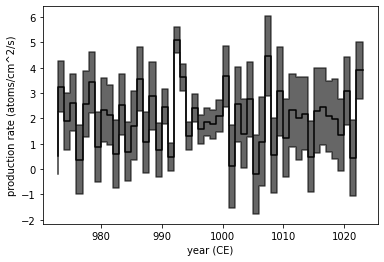

In [3]:
fig, ax = plt.subplots()
mean = np.mean(chain, axis=0)
std = np.std(chain, axis=0)
ax.errorbar(sf.time_data,mean, color='black', drawstyle="steps")
ax.fill_between(sf.time_data, mean-std, mean+std,step='pre', alpha=0.6,facecolor=(0,0,0,.1),edgecolor=(0,0,0,0.8), lw=1.5)
plt.xlabel("year (CE)")
plt.ylabel("production rate (atoms/cm^2/s)")
plt.show()

In [4]:
def tt(time, aa):
    return jnp.interp(time,sf.time_data,aa)

sf.compile_production_model(tt)

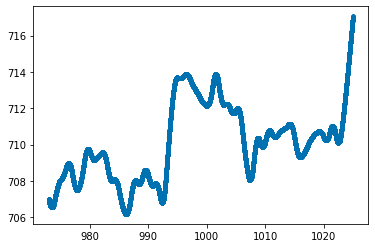

In [7]:
event = sf.run_event(y0=sf.steady_state_y0, params=(mean,))
time_values = jnp.linspace(jnp.min(sf.annual), jnp.max(sf.annual) + 2, (sf.annual.size + 1) * sf.oversample)
plt.plot(time_values, event[:,1], ".")

binned_data = sf.cbm.bin_data(event[:, sf.box_idx], sf.oversample, sf.annual, growth=sf.growth)
gaga = (binned_data - sf.steady_state_y0[sf.box_idx]) / sf.steady_state_y0[sf.box_idx] * 1000

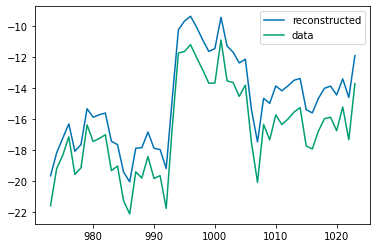

In [6]:
fig, ax = plt.subplots()
# ax.errorbar(sf.time_data,gaga+sf.offset, fmt='o')
# ax.plot(sf.time_data, sf.d14c_data, 'o')

ax.plot(sf.time_data,gaga+sf.offset)
ax.plot(sf.time_data, sf.d14c_data)
ax.legend(['reconstructed', 'data'])
plt.show()